In [197]:
pip install -r requirements.txt

     |████████████████████████████████| 160 kB 3.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [173]:
import pandas as pd
import nltk
import datetime
from nltk import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import random
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/tomfox/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomfox/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tomfox/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [174]:
# read in all of the data and load it into dataframes
plantBasedDf = pd.read_csv('plantBasedDf.csv')
veganDf = pd.read_csv('veganDf.csv')
vegetarianDf = pd.read_csv('vegetarianDf.csv')
flexitarianDf = pd.read_csv('flexitarianDf.csv')
labGrownDf = pd.read_csv('labGrownDf.csv')

# concat the dataframes and a diet type column
df = pd.concat([plantBasedDf, veganDf, vegetarianDf, flexitarianDf, labGrownDf])
df['diet'] = ['plantBased'] * len(plantBasedDf) + ['vegan'] * len(veganDf) + ['vegetarian'] * len(vegetarianDf) + ['flexitarian'] * len(flexitarianDf) + ['labGrown'] * len(labGrownDf)

In [175]:
# remove all rows with [removed] or [deleted] in the text column
df = df.drop(df[(df['text'] == '[removed]') | (df['text'] == '[deleted]')].index)

In [176]:
# anonymize redditor column
df['redditor'] = df['redditor'].apply(lambda x: 'redditor' + str(hash(x) % 10000))

# anonymize subreddit column
df['subreddit'] = df['subreddit'].apply(lambda x: 'subreddit' + str(hash(x) % 10000))

# anonymize title column
df['title'] = df['title'].apply(lambda x: 'title' + str(hash(x) % 10000))

In [177]:
# tokenize the text
df['tokenized_text'] = df['text'].apply(nltk.word_tokenize)

In [178]:
# remove punctuation
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item.isalpha()])

In [179]:
# remove stopwords
stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item not in stop_words])

In [180]:
# lemmatize the text
lemmatizer = nltk.stem.WordNetLemmatizer()
df['lemmatized_text'] = df['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [181]:
# lowercase the text
df['lemmatized_text'] = df['lemmatized_text'].apply(lambda x: [y.lower() for y in x])

In [182]:
# shuffle the order of items in lemmatized_text column to anonymize
df['lemmatized_text'] = df['lemmatized_text'].apply(lambda x: random.sample(x, len(x)))

In [183]:
# combine the text back into one string
df['processed_text'] = df['lemmatized_text'].apply(lambda x: ' '.join(x))

In [184]:
# remove the columns that are no longer needed
df = df.drop(['tokenized_text'], axis=1)

In [186]:
# save the processed dataframe to csv
df.to_csv('df.csv', index=False)

In [187]:
# groupby diet type
groupedDf = df.groupby('diet')

# number of posts per diet type
groupedDf.size()

diet
flexitarian     1434
labGrown       13630
plantBased      9796
vegan          14867
vegetarian     14023
dtype: int64

In [193]:
# counts for each word per diet type and top 10 words
top10count = groupedDf['lemmatized_text'].apply(lambda x: pd.Series([item for sublist in x for item in sublist]).value_counts().head(10))
top10count

diet                   
flexitarian  i              2678
             meat            876
             vegan           601
             people          578
             eat             544
             vegetarian      442
             animal          389
             like            374
             diet            323
             eating          321
labGrown     i             13361
             meat          10586
             would          3578
             lab            3120
             animal         2885
             like           2694
             eat            2640
             grown          2453
             taste          2002
             if             1909
plantBased   i              9645
             meat           5306
             cat            2799
             like           2473
             vegan          2118
             animal         1882
             eat            1840
             would          1608
             get            1436
             plant 

<AxesSubplot:xlabel='diet,None'>

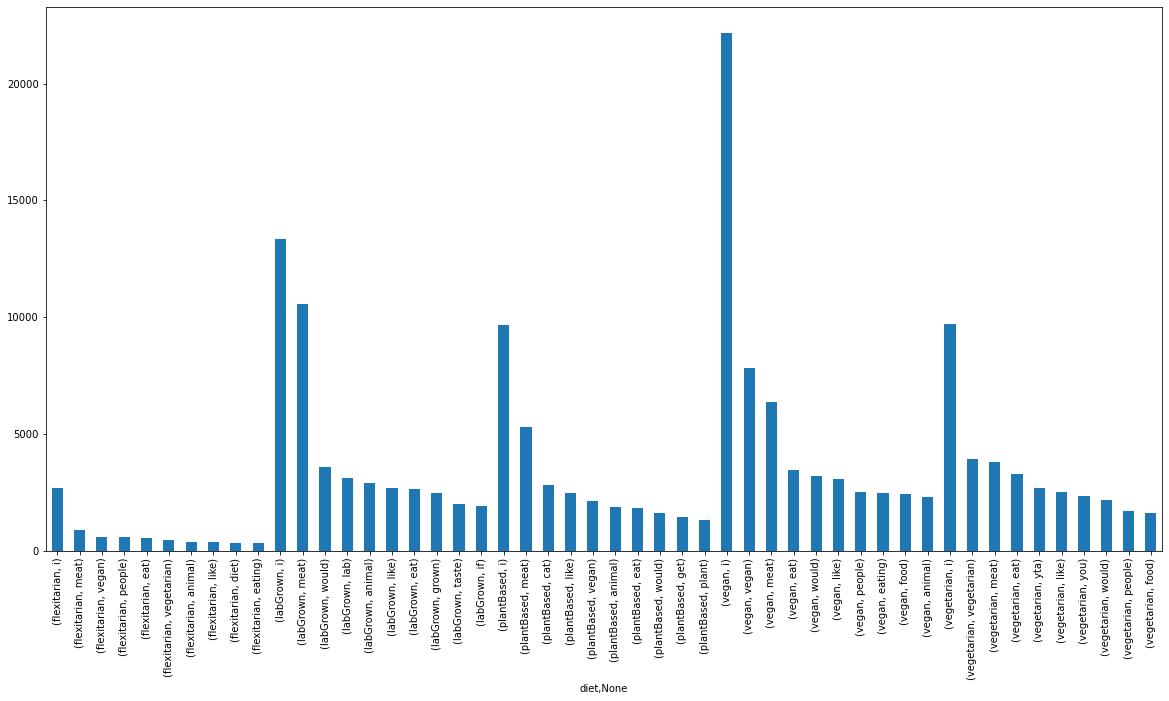

In [195]:
# bar chart of the top 10 words
top10count.plot.bar(figsize=(20,10))

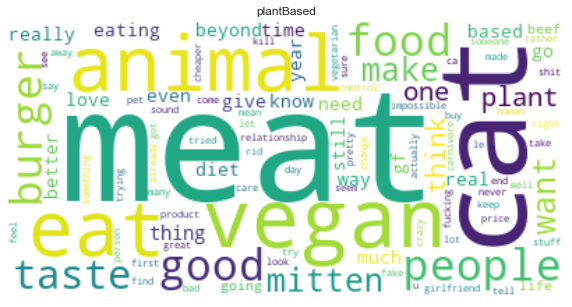

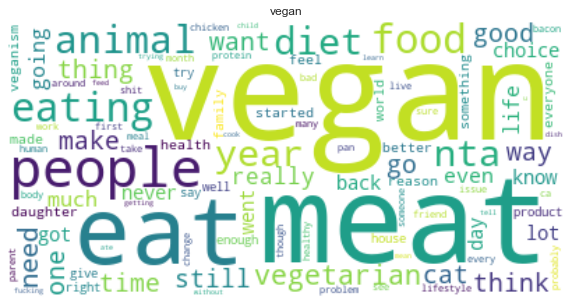

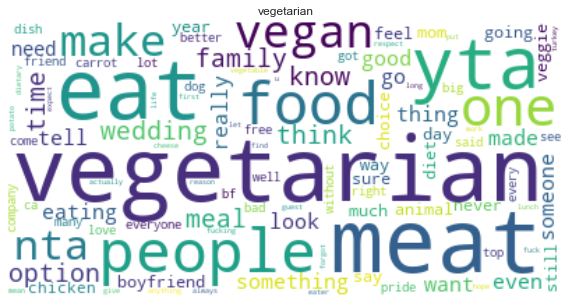

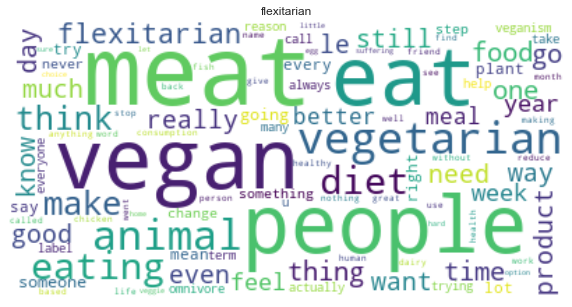

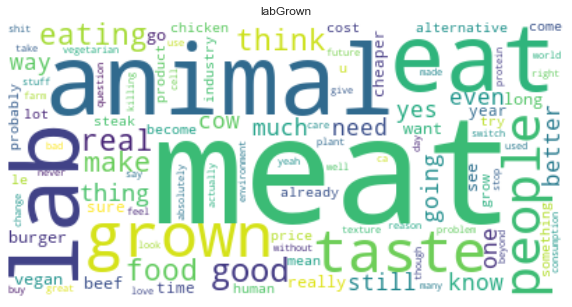

In [209]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np

# wordcloud for each diet type
for diet in df['diet'].unique():
    text = ' '.join(df[df['diet'] == diet]['lemmatized_text'].apply(lambda x: ' '.join(x)))
    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(diet)
    plt.show()

### 500 word description of the data collection process

To collect the data for this project, I used the Praw library to gether comments using the Reddit API. I chose to use comments instead of posts because I wanted to see what people were saying about each diet type, and not just the title of the post.

I used the following diets as my search terms: plant-based, vegan, vegetarian, flexitarian and lab-grown meat. I chose these diets because there is often a perception that the term 'vegan' can be devisive and off putting to people. This has led to companies and groups using terms such as 'plant-based' and 'flexitarian' to describe their products and diets. Others suggest that although the term 'vegan' used to be problematic it is now more widely accepted. The aim of this project is to see if there is a difference in the language used in comments about these diets.

I searched the whole of reddit for the chosen terms. I chose to be fairly unselective with the posts I picked, sorting by the posts with the most comments and taking all that had at least 2000 comments (with the exception of flexitarian, which had less than 2000 comments). I also only took posts which either had the search term in the title or were very obviously refering to the diet. I was only able to request the comments for a subsection of the posts becuase of processing limitations - I tooke the first 10 or 15 posts with the aim of having a similar number of comments for each diet.

Currently, I have kept all comments but I am considering only analysing comments which have the search term in them. To clean the data, I removed all of the comments which had been marked as [removed] or [deleted], I also hashed and shuffled certain columns to protect the privacy of the redditors in the dataset. I then tokenised the comments, removed punctuation and stopwords, lemmatized them and made all words lower case. The final dataset contains the original comment, the lemmatised comment, processed comment (as a string) and the diet type.

The dataset isnt fully anonamzied due to the need to show the process, but if necessary this could be done by removing the original commment, datetime and upvotes columns and possibly even the hashed columns.

The dataset is available to download from my GitHub repository:
https://github.com/TomWFox/nlp

